In [1]:
'''
filepath will point to current location of the Jupyter Notebook. Creates a folder for downloading data into, and another for figures.
'''
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('data'):
    os.mkdir('data')
else:
    print("'data' directory already exists'")
if not os.path.exists('figures'):
    os.mkdir('figures')
else:
    print("'figures' directory already exists'")
filepath = os.getcwd()

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk
'data' directory already exists'
'figures' directory already exists'


In [202]:
'''
work_dir should point to location of DEM  and .h5 files
'''
work_dir = os.path.expanduser('~/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo') 

In [148]:
'''
Import packages
'''
from netCDF4 import Dataset
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
from matplotlib import patheffects, rc, rcParams
import matplotlib.dates as mdates
from matplotlib.patches import ConnectionPatch, Polygon
from matplotlib.ticker import LogFormatterExponent
import matplotlib.font_manager as font_manager

plt.rcParams["font.family"] = 'serif'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text', usetex=True)

from datetime import datetime, timedelta
import datetime as dt

import pandas as pd
import calendar

from mintpy.simulation.plot import *
from mintpy.objects import sensor
from mintpy.utils import readfile, plot as pp, utils as ut
from mintpy import view

import string as STRING

from scipy.sparse import diags
import pylab

import warnings
warnings.filterwarnings('ignore')

print("All packages imported")

All packages imported


In [50]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)

'''
Defines a few colours used later
'''
vir_b = plt.cm.viridis_r(255)
vir_y = plt.cm.viridis_r(0)

'''
For formatting logarithmic axis labels
'''
class LogFormatterTexTextMode(LogFormatterExponent):
    def __call__(self, x, pos=None):
        x = LogFormatterExponent.__call__(self, x,pos)
        s = r"10\textsuperscript{{{}}}".format(x)
        return s

In [6]:
'''
Generate 'data_url.txt' file with list of urls required for data download. The default is to download all data from 01 Mar 2000 up until yesterday. 
A window of dates can be entered instead, for example: 

data_range(first=dt.date(2018, 12, 15), last=dt.date(2018,12,18))

'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data

prefix = 'https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_RT/TRMM_3B42RT_Daily.7/'

suffix = '.7.nc4\n'

yesterday = dt.date.today() - timedelta(1)

start_date = dt.date(2000, 3, 1)

def data_range_string(first = None, last = yesterday):
    data_dates = last - first
    for j in range(data_dates.days + 1):
        yield (first + timedelta(days = j)).strftime('%Y/%m')+'/3B42RT_Daily.'+(first + timedelta(days = j)).strftime('%Y%m%d')


string_list = list(data_range_string(first = start_date))#, last=dt.date(2018,12,18)))

with open("data_url.txt", "w") as output:
    for line in list([ prefix+x+suffix for x in string_list ]):
        output.write(str(line))

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk/data


In [7]:
'''
Access and download data files specified in data_url using wget. Will skip previously downloaded files.

Note: despite -nv, will be verbose if large number of new datafiles are being accessed. 
Right-click on cell and Enable Scrolling for Outputs, if necessary. One can change -nv to -q, but it may be useful to have some output.
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
!wget -nv -i data_url.txt -nc -c 
print('Data retrieved')

Data retrieved


In [8]:
import datetime as dt
'''
Opens textfile with list of data urls. Removes useless characters and returns a list of filenames for later use, as well as a list of dates. 
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
datafile = 'data_url.txt'
f = open(datafile)
f.seek(0)
fileIDs = f.readlines()
f.close()
fileIDs = [line.rstrip('\n') for line in fileIDs]
fileIDs = [line.lstrip(prefix) for line in fileIDs]
file_list =[]
for j,k in enumerate(fileIDs):
    text = fileIDs[j]
    if text.endswith('nc4'):    # Only deals with files that are netcdf format
        file_list.append(fileIDs[j][7:])
    else:
        continue
file_names = []
for j,k in enumerate(file_list):
    file_names.append(file_list[j][13:21])
fd =[]
for j,k in enumerate(file_names):
    fd.append(file_names[j][0:4]+'-'+file_names[j][4:6]+'-'+file_names[j][6:])
file_dates = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in fd]
print("Dates available : {} to {}".format(file_dates[0], file_dates[-1]))

Dates available : 2000-03-01 to 2019-09-04


In [9]:
'''
Open netcdf files and extract information.
'''

if os.getcwd() != filepath+'/data':
    %cd $filepath/data
    
ncFid = Dataset(file_list[0],"r", format = "NETCDF4") # Open just the first file to extract latitude and longitude data
longitude = ncFid.variables['lon'][:]
latitude = ncFid.variables['lat'][:]
ncFid.close() # Close file once done

precipitation = [] # Create precipitation variable
start_dates = [] # Create date variable
m = -1
for j,k in enumerate(file_list): # Interrogates file_list as defined above
    ncFid = Dataset(file_list[j],"r", format = "NETCDF4")
    precipitation.append(np.transpose(ncFid.variables['precipitation'][:])) # Iteratively append precipitation data
    start_dates.append(np.transpose(ncFid.BeginDate)) # Iteratively append date information
    ncFid.close() # Close file before opening next
    if j % int(np.ceil(len(file_list)/100)) == 0:
        m += 1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
print("{} dates".format(len(precipitation)))        

01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  7127 dates


In [10]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")
volcanoes = list(set(eruption_list.Volcano_Name)) ## different volcanoes with same name?
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.'.format(
    len(volcano_list),len(eruption_list),len(volcanoes)))                           

--2019-09-05 10:57:18--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [        <=>         ]   2.02M  1.19MB/s    in 1.7s    

2019-09-05 10:57:21 (1.19 MB/s) - ‘Holocene_eruptions.csv’ saved [2117115]

--2019-09-05 10:57:21--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volc

In [11]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Adds longitudes to original dataframe
print('Done\nand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locationlist = locations.values.tolist
print('Done')

Done
and
Done


In [12]:
'''
Creates dataframe with eruption information for all active volcanoes
'''
volcano_countries = volcano_list.set_index('Country')
all_active_volcanoes = pd.merge(eruption_list,volcano_countries, how = 'inner', on = ['Volcano_Name'])

'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

volcano_set_name = []
volcano_set_lat = []
volcano_set_lon = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in volcano_set_name:
        volcano_set_name.append(k)
        volcano_set_lat.append(all_active_volcanoes.lats[j])
        volcano_set_lon.append(all_active_volcanoes.lons[j])

volcano_set = pd.DataFrame({'Name' :volcano_set_name,'lat' : volcano_set_lat, 'lon' : volcano_set_lon})
volcano_set.set_index('Name', inplace = True)

In [13]:
'''
Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
and typically correspond to the summit or centre of the caldera region.
'''
name_volc = 'Kilauea'
lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
lon_volc = volcano_set.loc[[name_volc]].lon.values[0]

j_volc = min(longitude, key=lambda x:abs(x-lon_volc))
i_volc = min(latitude, key=lambda x:abs(x-lat_volc))

In [15]:
'''
Shapefile of Big Island faults: 
University of Hawaii. (2015). Hawaii Faults [data set].  Retrieved from http://gdr.openei.org/submissions/532.
'''
#os.chdir(filepath)
faults = gpd.read_file("../Hawaii_Faults.shp")

In [16]:
'''
Name and location data for five GPS stations 
'''
stations = ["CRIM","AHUP","KOSM", "KTPM", "MKAI", ]
stat_lats=[19.395,19.379,19.363, 19.341,  19.356, ]
stat_lons=[ -155.274, -155.266,-155.316, -155.160, -155.176, ]

In [18]:
'''
Read in GPS data from .csv files
'''
    
crim = pd.read_csv(filepath+'/gps/gps_CRIM.csv')
ahup = pd.read_csv(filepath+'/gps/gps_AHUP.csv')
kosm = pd.read_csv(filepath+'/gps/gps_KOSM.csv')
ktpm = pd.read_csv(filepath+'/gps/gps_KTPM.csv')
mkai = pd.read_csv(filepath+'/gps/gps_MKAI.csv')

gps_dict = {}
frame_list = [crim, ahup, kosm, ktpm, mkai]
frame_names = ["crim","ahup", "kosm","ktpm", "mkai"]
for num, frame in enumerate(frame_list):
    frame.name = frame_names[num]
for frame in frame_list:
    frame_name = frame.name+"_data"
    string_dates = []
    for string in frame.YYMMMDD:
        string=str(string)
#         if type(string)=='str':
        string=string.replace("-","")
        if string[0:2] == '99':
            string_dates.append(datetime.strptime(("19"+string), '%Y%b%d'))
        else:
            string_dates.append(datetime.strptime(("20"+string), '%Y%b%d'
                                                     ) if string[0:2].isdigit() else datetime.strptime(
                ("200"+string), '%Y%b%d'))
    gps_dict[frame_name] = pd.DataFrame({
        "date" : string_dates,
        "elev" : frame['u0(m)'],
        "up" : frame['____up(m)'],
        "error" : frame['sig_u(m)']
    })

In [19]:
# work_dir = os.path.expanduser('~/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo') ## ensure this points to work directory
os.chdir(work_dir)
print('Go to directory: '+work_dir)

Go to directory: /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo


In [20]:
'''
Point to DEM file
'''
dem_file = os.path.expanduser(work_dir+'/../../../srtm1_msk.dem') 

view.py ../../../up_2015_2017.h5 velocity -u cm/yr --sub-lat 18.95 20 --sub-lon -156 -154.800113373004 -c viridis --nocbar --vlim -10 10 --dem /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo/../../../srtm1_msk.dem --dem-nocontour --shade-min -4500 --shade-max 5000 --noscalebar --notitle --fontsize 6 --ref-size 2
run view.py in MintPy release version v1.1.2-56, release date 2019-06-28
input file is velocity file: /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/up_2015_2017.h5 in float64 format
file size in y/x: (1081, 1261)
turning glob search OFF for velocity file
num of datasets in file up_2015_2017.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1261, 1081)
subset coverage in y/x: (0, 0, 1260, 1081)
data   coverage in lat/lon: (-155.500277778, 19.800277778, -154.799721662, 19.199721742)
subset coverage in lat/lon: (-155.500277778, 19.800277778, -154.800277218, 19.199721742)
---------------------------

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


view.py ../../../up_2018.h5 velocity -u cm/yr --sub-lat 18.95 20 --sub-lon -156 -154.800113373004 -c viridis --nocbar --vlim -10 10 --dem /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo/../../../srtm1_msk.dem --dem-nocontour --shade-min -4500 --shade-max 5000 --noscalebar --notitle --fontsize 6 --ref-size 2
run view.py in MintPy release version v1.1.2-56, release date 2019-06-28
input file is velocity file: /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/up_2018.h5 in float64 format
file size in y/x: (1081, 1261)
turning glob search OFF for velocity file
num of datasets in file up_2018.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1261, 1081)
subset coverage in y/x: (0, 0, 1260, 1081)
data   coverage in lat/lon: (-155.500277778, 19.800277778, -154.799721662, 19.199721742)
subset coverage in lat/lon: (-155.500277778, 19.800277778, -154.800277218, 19.199721742)
------------------------------------------

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


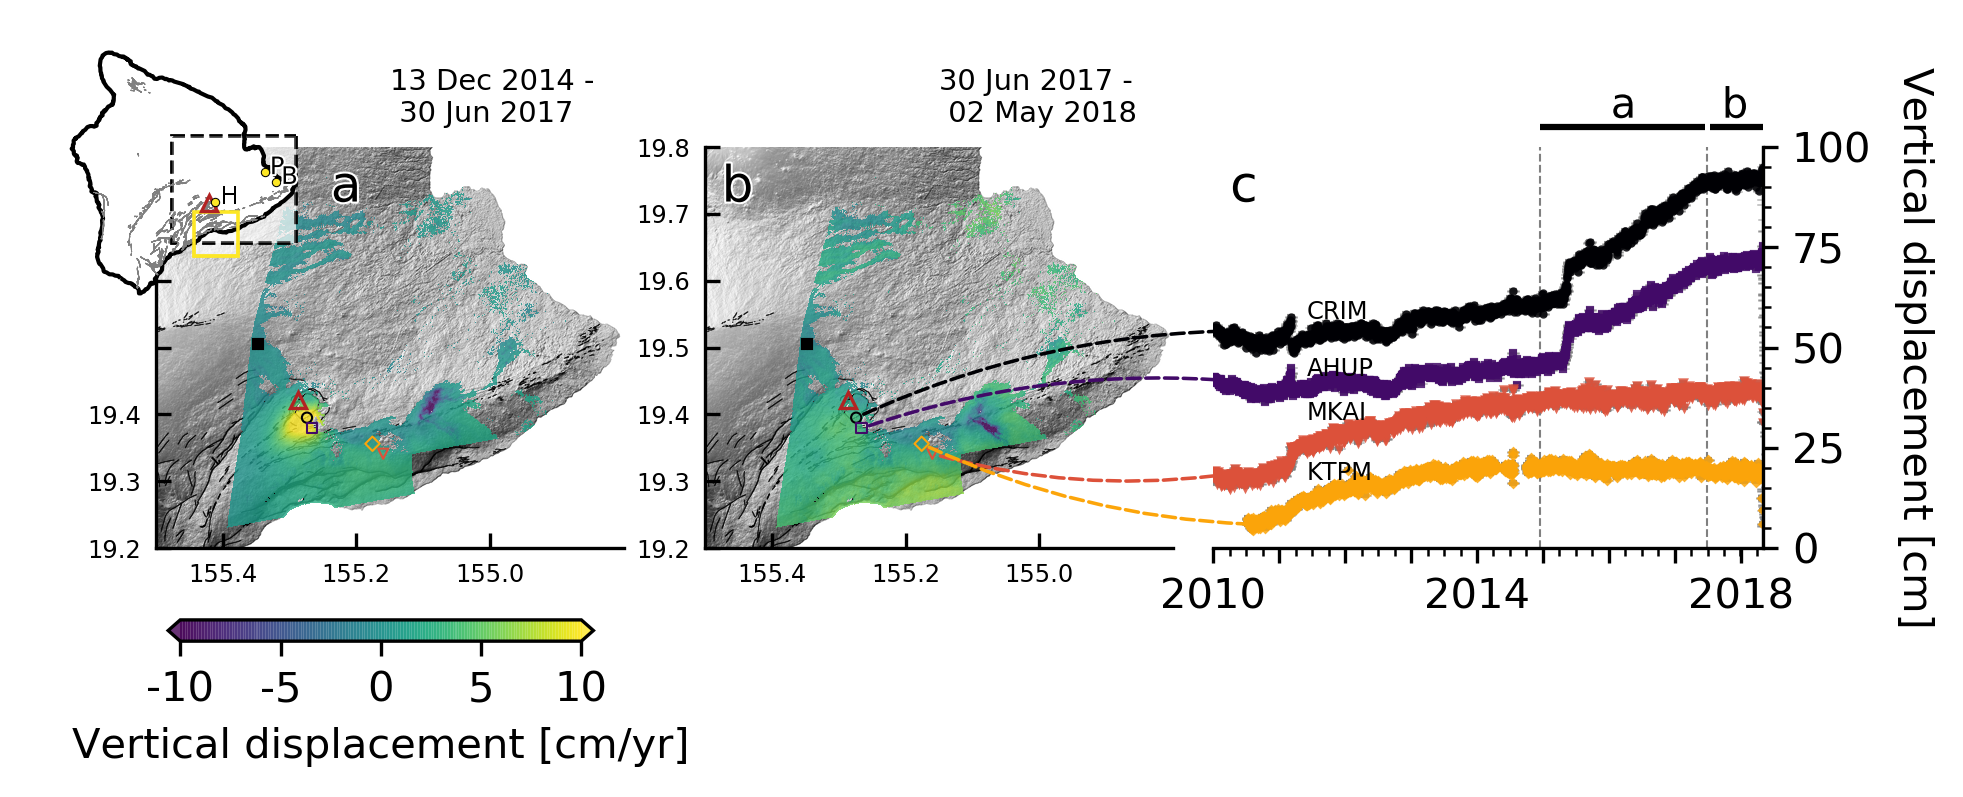

In [23]:
'''
Plots Figure 1 based on imported velocity files via mintpy's view function.
'''

colmap = matplotlib.cm.get_cmap('inferno') #colormap for GPS data
W, N, E, S = (-156, 20, -154.800113373004, 18.95)
buffer = [patheffects.withStroke(linewidth=1, foreground="white")]


fig = plt.figure(figsize=mm2inch(180, 45), dpi = 300)
gs = plt.GridSpec(1, 3, figure=fig, wspace=0
                 )
plt.rcParams["font.family"] = 'sans-serif'

axs = [fig.add_subplot((gs[0, 0])),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),]


vel_files = (["../../../up_2015_2017.h5",
              "../../../up_2018.h5",
             ])
marker_shapes = ["o", "s", "*", "v", "D"]
marker_colors = [colmap(x) for x in np.arange(0,1.1,0.2)]

########### panel a & b ###########
start_dates = []
end_dates = []
for i in range(len(vel_files)):
    ax = axs[i]
    cmd =  'view.py {} velocity -u cm/yr '.format(vel_files[i])
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c viridis --nocbar --vlim -10 10 '
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(dem_file)
    cmd += '--noscalebar --notitle --fontsize 6 --ref-size 2'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    s_date = '{2} {1} {0}'.format(atr["START_DATE"][0:4],calendar.month_abbr[int(atr["START_DATE"][4:6])],atr["START_DATE"][6:])
    e_date = '{2} {1} {0}'.format(atr["END_DATE"][0:4],calendar.month_abbr[int(atr["END_DATE"][4:6])],atr["END_DATE"][6:])
    ax.set_title("{} -\n {}".format(s_date,e_date), fontsize = "x-small", ha="left")#, y=-0.04)
    
    kil_lalo = (lat_volc, lon_volc)
    ax.plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='firebrick', mfc='none', mew=0.8)

    faults.plot(ax = ax, marker = ".",markersize=0.25, color = "k",edgecolor = "None", zorder = 1, alpha = 0.5)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x))
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(-x))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.xaxis.set_major_formatter(ticks_x)
    ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    for j,k in enumerate([0,1,3,4]):#stations):
        ax.scatter(stat_lons[k], stat_lats[k], marker = marker_shapes[k], s=6,
                   facecolor = "None", edgecolor = marker_colors[k],linewidth = 0.5,
                   zorder = 11, label=k)
    start_dates.append(datetime(int(atr["START_DATE"][0:4]), int(atr["START_DATE"][4:6]), int(atr["START_DATE"][6:8])))
    end_dates.append(datetime(int(atr["END_DATE"][0:4]), int(atr["END_DATE"][4:6]), int(atr["END_DATE"][6:8])))
############# panel c #############
n = 1
first_date = datetime.strptime("20100101", '%Y%m%d')
for num, frame in enumerate(frame_names):
    if frame!='kosm':# and frame!='kosm':# in ["crim", "ktpm", "mkai"]:
        frame = frame+'_data'
        frame = gps_dict[frame]
        if frame.date[0] <= first_date: 
            first = frame[frame.date == "2010-01-01"].up.values
        else:
            first = frame.up[0]
        axs[2].errorbar(frame.date[::n], frame.up[::n]-first # displacement since 2010
                     +(-.12*num+.54), # manual offset for clarity
                     frame.error[::n], fmt=marker_shapes[num],ms=1,
                 mfc = "None",mec=marker_colors[num],ecolor='grey', capsize=1, elinewidth=3, alpha = 0.85)
axs[2].set_xlim("2010-01-01", "2018-05-02")        
axs[2].set_ylim(0,1)#-0.1,1)
axs[2].set_ylabel("Vertical displacement [cm]", rotation = 270, labelpad = 15)
axs[2].axvline(x="2014-12-13", linewidth = 0.5, linestyle = "dashed", color = "grey", zorder = 0)
axs[2].axvline(x="2017-06-30", linewidth = 0.5, linestyle = "dashed", color = "grey", zorder = 0)
axs[2].axvline(x="2018-05-03", linewidth = 0.5, linestyle = "solid", color = "k", zorder = 0)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
axs[2].yaxis.set_major_formatter(ticks_y)
years = mdates.YearLocator()  
axs[2].xaxis.set_major_locator(years)
axs[2].set_xticklabels([str(x) for x in range(2010, 2020,)])
ln = 4  # Keeps every nth label
[l.set_visible(False) for (i,l) in enumerate(axs[2].xaxis.get_ticklabels()) if i % ln != 0]
note_locs =[0.57,0.43,0.3,0.17,0.32] # [0.1,0.2,0.3,0.4,0.5]
for num, frame in enumerate(frame_names):
    if num in [0,1,3,4]:
        axs[2].annotate(frame.upper(), xy=("2011-01-01",note_locs[num]),
                        xycoords='data', xytext=("2011-06-01",note_locs[num]),fontsize = "xx-small")
axs[2].spines["left"].set_visible(False)
axs[2].spines["top"].set_visible(False)
axs[2].hlines(xmin = "2014-12-13", xmax = "2017-06-15", y = 1.05, clip_on=False)
axs[2].hlines(xmin = "2017-07-15", xmax = "2018-05-02", y = 1.05, clip_on=False)

for num, label in enumerate(["a", "b"]):
    axs[2].annotate(label, xy = ((start_dates[num]+(end_dates[num]-start_dates[num])/2),1),
               xycoords='data',xytext = ((start_dates[num]+(end_dates[num]-start_dates[num])/2),1.15),
                color='k',fontsize = 10, path_effects = buffer,ha='center',
                    va='top', zorder = 1000)

####### colorbar ####
cax = fig.add_axes([0.15, -0.05, 0.2, 0.04])#[0.15, -0.1, 0.45, 0.04])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-10,-5, 0, 5,10], extend="both", extendfrac=.03)
cbar.set_label('Vertical displacement [cm/yr]')#, fontsize="small")#, labelpad= 15, rotation = 270)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.xaxis.set_ticks_position('bottom')
ticks_cb = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
cax.xaxis.set_major_formatter(ticks_cb)

###### mapax #####

axs.append(fig.add_axes([0.07,0.6, 0.18, 0.5]))
m = Basemap(llcrnrlon=-156.3,#W,
            llcrnrlat=18.9,#S,
            urcrnrlon=-154.5,#-154.7,#E,
            urcrnrlat=20.4,#N,
            projection='cyl',
            resolution = 'h',
            area_thresh=110,
            ax=axs[3])
m.drawcoastlines(linewidth = 1, color = 'k')
m.fillcontinents(color='w')

x1,y1 = (j_volc+0.25,i_volc)
x2,y2 = (j_volc+0.25,i_volc-0.25)
x3,y3 = (j_volc,i_volc-0.25)
x4,y4 = (j_volc,i_volc)
poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='None',hatch = '', edgecolor=vir_y, linestyle = "solid",linewidth=.85,
                zorder = 10)
axs[3].add_patch(poly)
poly2 = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],facecolor='w',hatch = '', edgecolor=vir_y, linestyle = "solid",linewidth=.85,
                zorder = 1, alpha = 0.7)
axs[3].add_patch(poly2)

W, N, E, S = (-155.5, 19.8, -154.8, 19.2)
poly3 = Polygon([(E,N), (E,S), (W,S), (W,N)], facecolor='None', edgecolor = 'k', linestyle ="dashed", linewidth =.85)
axs[3].add_patch(poly3)
poly4 = Polygon([(E,N), (E,S), (W,S), (W,N)], facecolor='w', edgecolor = 'k', linestyle ="dashed", linewidth =.85, zorder = 1, alpha = 0.7)
axs[3].add_patch(poly4)

axs[3].axis('off')
buffer = [patheffects.withStroke(linewidth=1, foreground="white")]
faults.plot(ax = axs[3], marker = ".",markersize=0.25, color = "grey",edgecolor = "None", zorder = 10, alpha = 0.85)

axs[3].plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='firebrick', mfc='none', mew=0.8, zorder = 11)
axs[3].annotate(r"H", xy = (-155.2562, 19.4297), #HVNP rain gauge
             xytext=(-155.2562+0.03, 19.4297-0.01),
             fontsize = "xx-small",
            path_effects=buffer)
axs[3].annotate(r"P", xy = (-154.976, 19.596), #Paradise Park rain gauge
             xytext=(-154.976+0.03, 19.596-0.01),
             fontsize = "xx-small",
            path_effects=buffer) #19.596, -154.976
axs[3].annotate(r"B", xy = (-154.91194,19.54111), #Beaches rain gauge
             xytext=(-154.91194+0.03, 19.54111-0.01), #19.54111, -154.91194
             fontsize = "xx-small",
            path_effects=buffer, zorder = 20)

axs[3].scatter(-155.2562, 19.4297, marker = '.', s=16, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)
axs[3].scatter(-154.976, 19.596, marker = '.', s=16, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)
axs[3].scatter(-154.91194, 19.54111, marker = '.', s=16, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)


##### figure additions #####

axs[2].set_zorder(-1)    
arc_rad =[-0.1,-0.1,-0.1,0.1,0.1]
# arc_rad =[0.1,0.1,0.1,-0.1,-0.1]
for num, frame in enumerate(frame_names):
    offset = -.12*num+.54
    if num!=2:
        frame = frame+'_data'
        frame = gps_dict[frame]
        if frame.date[0] <= first_date: 
            first = frame[frame.date == "2010-01-01"].up.values
            xy_b = (frame[frame.date == "2010-01-01"].date.values,
                    frame[frame.date == "2010-01-01"].up.values-first+offset)
        else:
            xy_b = (frame.date[0], offset)#(frame.up[0]+(-.12*num+.54)))
        con = ConnectionPatch(xyA=(stat_lons[num],stat_lats[num]), xyB=xy_b, coordsA="data", coordsB="data",
                          axesA=axs[1], axesB=axs[2], color=marker_colors[num],
                          connectionstyle = "arc3,rad={}".format(arc_rad[num]),
                          linestyle="--",
                          shrinkA=2, shrinkB=0,linewidth = 0.85,
                           fc=marker_colors[num], zorder = 99)
        axs[1].add_artist(con)
text_coord = [42,4,4] 
for num in range(0,3):
    axs[num].annotate(STRING.ascii_lowercase[num], (0, 1),xytext=(text_coord[num], -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)

axs[2].minorticks_on()

[l.set_visible(False) for (i,l) in enumerate(axs[0].yaxis.get_ticklabels()) if not i in range(4)]
# plt.savefig(filepath+"/figures/kil_fig_1.png", bbox_inches="tight")
plt.show()

**Figure 1 |** Pre-eruption ground deformation of study site. a Vertical deformation map derived from Sentinel-1 InSAR data (ascending track 124 and descending track 87) between Dec 2014 and Jun 2017. [inset] Location map of Kīlauea Volcano (open triangle), and the HVNP rain gauge (H) within the Eastern Rift Zone (fault lines shown in black). Solid line yellow box indicates the 0.25 × 0.25 ° TRMM/GPM footprint used in this study. Paradise Park Well (P) and Hawaiian Beaches rain gauge (B) are also highlighted (see Supplementary Information 1). Dashed box indicates region shown in a and b. In a and b, filled square is reference point, Open symbols represent GPS station locations. b Vertical deformation between Jun 2017 and May 2018. c Vertical GPS displacement of Kīlauea flank from 2010. Station IDs are shown on the panel; symbols correspond to locations in a and b. Dashed vertical lines highlight significant change-of-slope in station data proximal to the summit (CRIM, AHUP). Datasets have been offset from x-axis for clarity.

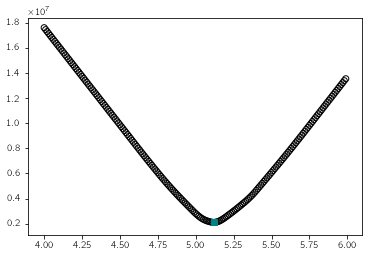

Scale factor : 5.12


In [150]:
'''
Read in available rain gauge data near Kilauea
''' 
kilauea_gauge = pd.read_csv(filepath+"/gauge_data/1679027.csv")
long_term_gauge = pd.read_csv(filepath+"/gauge_data/1738950.csv")

lt_datetimes = []
lt_dates =[]

for j in long_term_gauge.DATE:
    lt_datetimes.append(dt.datetime.strptime(j, "%Y-%m-%d"))
for j in lt_datetimes:
    lt_dates.append(dt.date(j.year,j.month,j.day))
long_term_gauge["dates"] = lt_dates


ki_datetimes = []
ki_dates =[]

for j in kilauea_gauge.DATE:
    ki_datetimes.append(dt.datetime.strptime(j, "%Y-%m-%d"))
for j in ki_datetimes:
    ki_dates.append(dt.date(j.year,j.month,j.day))
kilauea_gauge["dates"] = ki_dates

hvnp = kilauea_gauge[kilauea_gauge.NAME == 'HAWAII VOL. NATIONAL PARK HQ. 54, HI US'].reset_index()
#volc = kilauea_gauge[kilauea_gauge.NAME == 'VOLCANO 4.3 SSE, HI US'].reset_index()

hvnp["cum"] = hvnp.PRCP.cumsum()
#volc["cum"] = volc.PRCP.cumsum()

'''
Append precipitation data from TRMM/ GPM data for Kilauea geolocation 
(i.e. lat/lon defined by i_volc and j_volc.)
'''
ki_rainfall = []
for j,k in enumerate(precipitation):
    ki_rainfall.append(precipitation[j][list(latitude).index(i_volc)][list(longitude).index(j_volc)])

ki_rain = pd.DataFrame({"date": file_dates, "rain": ki_rainfall})
ki_rain["cum"] = ki_rain.rain.cumsum()

lt_ki_rain = pd.DataFrame({"date": long_term_gauge.dates, "rain": long_term_gauge.PRCP})
lt_ki_rain.rain = lt_ki_rain.rain*25.4  # inches to mm
lt_ki_rain["cum"] = lt_ki_rain.rain.cumsum()

'''
Determine the scale factor that minimises the residuals between the gauge and satellite datasets
'''
cum1=hvnp.cum

cum2=ki_rain.cum[0:len(hvnp.cum)]
resids = []
coeffs = np.arange(4,6,0.01)
for i in coeffs:
    cum_diff = []
    for j, k in enumerate(cum1):
        cum_diff.append(abs(k-(cum2[j]*i)))
    resids.append(np.nansum(cum_diff))
plt.scatter(coeffs,resids, marker = "o", edgecolor ="k", color = "None")  
scale_factor = coeffs[np.argmin(resids)]
plt.scatter(scale_factor, resids[np.argmin(resids)], marker = "s", color = "teal")
plt.show()

print("Scale factor : {:.2f}".format(scale_factor))

In [52]:
'''
Rainfall is calibrated according to gauge data
'''
rainfall = [x * scale_factor for x in ki_rainfall]
rainfall_m=rain_dates.rainfall/1e3 # rainfall in meters

rain_dates = pd.DataFrame( # dataframe containing "pentad" data (five-day running mean), for later use
    {'date':file_dates[:],
     'rainfall': rainfall
    })
j = 5
pentads = rain_dates.rainfall.rolling(j).mean()
pentads.fillna(0, inplace=True)

In [55]:
''' 
Creates and fills the "raindf" dataframe, which stores much of the information required for further time-series analysis etc. 
'''
raindf = pd.DataFrame(
    {'date':file_dates, ##
     'monthly_cumulative_mm': rainfall
    })
raindf.date = pd.to_datetime(raindf.date)
raindf = raindf.groupby('date').monthly_cumulative_mm.max()
raindf = raindf.groupby(raindf.index.to_period('M')).cumsum().reset_index()
raindf['daily_rainfall_mm'] = rainfall
raindf['mnth_yr'] = raindf.date.dt.to_period('M')
raindf['mnth'] = raindf.date.dt.month
raindf['day'] = raindf.date.dt.dayofyear
raindf['year'] = raindf.date.dt.year

threshold = 10
raindf['masked'] = raindf.monthly_cumulative_mm.mask(raindf.monthly_cumulative_mm < threshold)
raindf.index = raindf['date']
raindf[0:2]

,date,monthly_cumulative_mm,daily_rainfall_mm,mnth_yr,mnth,day,year,masked
date,,,,,,,,
2000-03-01,2000-03-01,2.7648,2.7648,2000-03,3,61,2000,NaN
2000-03-02,2000-03-02,4.4544,1.6896,2000-03,3,62,2000,NaN


In [61]:
'''
Total monthly rainfall values are calculated from 'raindf' and added to a new dataframe 'mnth_raindf'.
'''
year_mnth = sorted(set(raindf.mnth_yr))
monthly_sum = raindf.daily_rainfall_mm.groupby(raindf.mnth_yr).sum()
'''
Creates dataframe to manipulate monthly data
'''
mnth_raindf = pd.DataFrame(
    {'year_mnth':year_mnth,
     'monthly_sum':monthly_sum
    })
mnth_raindf.index = mnth_raindf.index.to_timestamp()

avgs = []
for k in (mnth_raindf.index.month):
    avgs.append(mnth_raindf.loc[mnth_raindf.index.month == k].monthly_sum.mean())
mnth_raindf['avg'] = avgs
mnth_raindf['differ'] = mnth_raindf.monthly_sum - mnth_raindf.avg

'''
Attributes colours to rainfall above or below average
'''
color_differ = []
for j in mnth_raindf.differ:
    if j>0:
        color_differ.append("firebrick")
    elif j<0:
        color_differ.append("teal")
print("Done")

Done


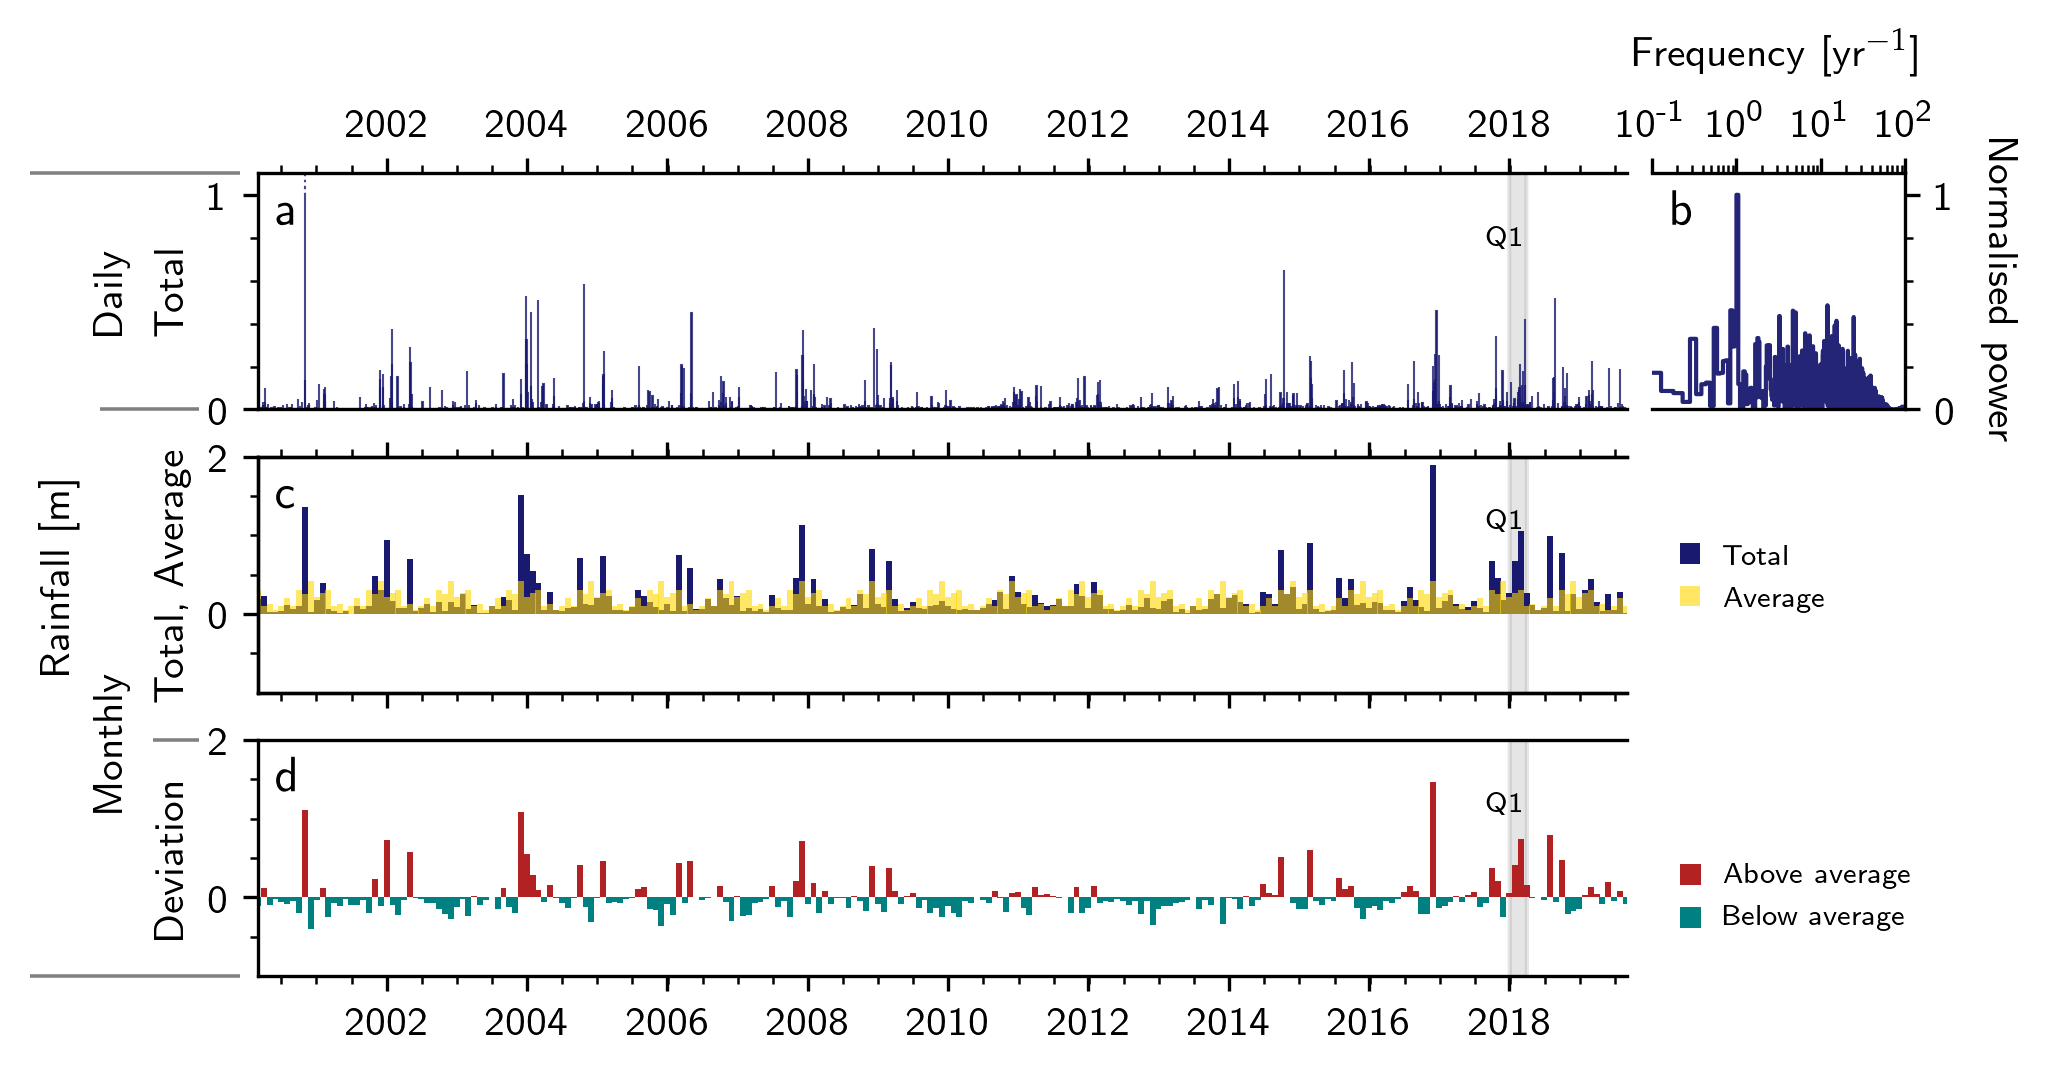

In [66]:
'''
Plots Figure 2 based on processed rainfall data.
'''
fig = plt.figure(figsize=mm2inch(180, 90), dpi = 300)
gs = plt.GridSpec(3, 6, figure=fig, wspace=0.1)

axs = [fig.add_subplot((gs[0, :-1])),
        fig.add_subplot(gs[0, -1]),
        fig.add_subplot(gs[1, :-1]),
      fig.add_subplot(gs[2,:-1])]

ys = np.arange(-2000,2100,0.5)
xax1 = ["2018-01-01" for y in ys]
xax2 = ["2018-03-31" for y in ys]
############### panel b ###############
A = np.fft.fft(pentads)
B = np.abs(A)**2

n = pentads.size
freq = np.fft.fftfreq(n, d= 1/365.25)
k = freq > 0

axs[1].set_xlim(0.1,100)
axs[1].set_ylim(0,1.1)
axs[1].step(freq[k],B[k]/max(B[k]),
            color = 'midnightblue',
            linestyle = 'solid',
            linewidth =1., alpha = 0.95, where = 'mid') # Normalised power versus frequency
plt.minorticks_on()

axs[1].set_ylabel("Normalised power", rotation = 270, labelpad = 15)
axs[1].set_xlabel(r'Frequency [yr$^{-1}$]', labelpad = 10)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[1].yaxis.set_major_formatter(ticks_y)
axs[1].xaxis.set_major_formatter(ticks_y)

axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right') 
axs[1].minorticks_on()

axs[1].set_xscale("log")
axs[1].xaxis.set_major_formatter(LogFormatterTexTextMode())
axs[1].minorticks_on()

axs[1].set_xticks([0.1,1,10,100])
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
axs[1].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)
axs[1].xaxis.set_minor_locator(locmin)
axs[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axs[1].spines["left"].set_visible(False)
################ panel b ###############

################ panel a ###############

axs[0].bar(file_dates,rainfall_m,
           color="midnightblue",
           linewidth = .5,
           edgecolor = "midnightblue",alpha =0.8)
axs[0].set_xlim(min(file_dates), max(file_dates))
axs[0].set_ylim(0, 1.1)#max(rainfall_m))
axs[0].set_ylabel('Total')
axs[0].set_yticks([0,1])
axs[0].spines['right'].set_visible(False)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[0].yaxis.set_major_formatter(ticks_y)
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].minorticks_on()
################ panel a ###############

################ panel c ###############
axs[2].bar(mnth_raindf.index,
           mnth_raindf.monthly_sum,
           color = 'midnightblue',
           edgecolor = 'midnightblue', width = 1,lw = 0, label = "Total")
axs[2].set_ylabel('Total, Average')
axs[2].bar(mnth_raindf.index,mnth_raindf.avg,
           width = 1, lw = 0.,
           color = "gold", edgecolor = "None",
           alpha = 0.6, label = "Average")
legend = axs[2].legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper left', bbox_to_anchor=(1.02, 0.75),#0.75),#bbox_to_anchor=(0.04, 1.05),
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)
axs[2].set_ylim([-1000,2000])
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
axs[2].yaxis.set_major_formatter(ticks_y)

axs[2].spines['right'].set_visible(False)

axs[2].set_xticklabels([])
axs[2].set_yticks([0,2000.0])
axs[2].set_xlim(min(file_dates), max(file_dates))
axs[2].minorticks_on()

ax8 = axs[2].twiny()
ax8.minorticks_on()
ax8.plot([],[]) # Dummy plot
ax8.set_xlim(min(file_dates), max(file_dates))
ax8.set_xticklabels([])
ax8.spines["right"].set_visible(False)

################ panel c ###############
################ panel d ###############
axs[3].bar(mnth_raindf.index, 
           mnth_raindf.differ, 
           color = color_differ, edgecolor = color_differ, 
           width = 1,linewidth = 0)
axs[3].set_ylabel('Deviation')
marker1 = plt.scatter([],[],marker = 's', s=25, edgecolor='None', linewidth = 0.8, facecolor = 'firebrick', alpha = 1.)
marker2 = plt.scatter([],[],marker = 's', s=25,edgecolor='None', linewidth = 0.8, facecolor = 'teal', alpha = 1.)
legend_markers = [marker1, marker2]
axs[3].legend([marker1, (marker2)], ["Above average", "Below average"],
          fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper left',bbox_to_anchor=(1.02, .6),
          framealpha=0)# loc = 'lower left')
axs[3].set_xlim([min(file_dates), max(file_dates)])
axs[3].set_ylim([-1000,2000])
axs[3].minorticks_on()

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
axs[3].yaxis.set_major_formatter(ticks_y)

axs[3].spines['right'].set_visible(False)

################ panel d #####################

################ annotations #################
axs[0].hlines(xmin="1996-12-01", xmax="1999-12-01",y=1.1, clip_on=False, linewidth = 0.85, color = "grey")
axs[0].hlines(xmin="1997-12-01", xmax="1999-05-01",y=0, clip_on=False, linewidth = 0.85, color = "grey")
axs[3].hlines(xmin="1996-12-01", xmax="1999-12-01",y=-1000, clip_on=False, linewidth = 0.85, color = "grey")
axs[3].hlines(xmin="1998-09-01", xmax="1999-05-01",y=2000, clip_on=False, linewidth = 0.85, color = "grey")

axs[0].fill_betweenx(y=ys, x1=xax1, x2=xax2, color = "grey", alpha = 0.2, zorder = 0)
axs[2].fill_betweenx(y=ys, x1=xax1, x2=xax2, color = "grey", alpha = 0.2, zorder = 0)
axs[3].fill_betweenx(y=ys, x1=xax1, x2=xax2, color = "grey", alpha = 0.2, zorder = 0)

for num in [0,2,3]:
    axs[num].annotate("Q1", xy =(0.925, 0.7), xycoords = "axes fraction", fontsize = "x-small", horizontalalignment='right' )


axs[0].annotate("Daily", xy = (-0.12,0.5), xycoords = "axes fraction", rotation = 90, va = "center")
axs[2].annotate("Rainfall [m]", xy = (-0.16,0.5), xycoords = "axes fraction", rotation = 90, va = "center")
axs[3].annotate("Monthly", xy = (-0.12,1), xycoords = "axes fraction", rotation = 90, va = "center")   

for num in range(0,4):
    axs[num].annotate(STRING.ascii_lowercase[num], (0, 1),xytext=(4, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)
for num in [1.08,1.05,1.02]:
    axs[0].hlines(xmin="2000-03-15", xmax="2002-01-01",y=num, clip_on=True, linewidth = 0.85, color = "w")
    
# plt.savefig(filepath+"figures/kil_fig_2.png", bbox_inches="tight")

plt.show()


**Figure 2 |** Rainfall over Kīlauea. a Calibrated daily rainfall amount over Kīlauea from Mar 2000 and July 2019 (TRMM/GPM data calibrated with gauge data; see Fig. 1a [inset] and Methods). b Power spectrum of Fourier-transformed rainfall time-series (a) shown in the (normalised) power–frequency domain. c Monthly rainfall since Mar 2000 at Kīlauea. Dark (blue) bars are sum total each month, light (yellow) bars are monthly average over the 2000–2019 time frame. d Deviation of monthly rainfall sum from the long-term (2000–2019) average for that month. The first quarter (Q1) of 2018 is highlighted where appropriate.

In [70]:
'''
Returns diffusivity value "alpha" based on input permeability "k", compressibility "beta", and porosity "phi" values.
Returns defaults if arguments aren't passed.
'''
def alpha(k=1e-15,beta=1e-10, phi=0.2):
    mu = 8.9e-4
    alpha = k/(beta*mu*phi)
    return alpha

In [ ]:
'''
Calculates three different average permeabilities for the edifice domain,
based on the width (wi) and permeability (ki)  of different components 
based on current hydrogeological understanding of Kilauea. 
These are the arithmetic mean permeability (kx), the harmonic mean permeability (kz), 
and the geometric mean permeability (kg).

'''
wi = [500,700, 4800]
ki = [1e-10,1e-14,1e-16]
kz = np.sum(wi)/np.sum(np.divide(wi,ki))
kx = np.sum(np.multiply(wi,ki))/sum(wi)
kg = np.exp(np.sum(np.multiply(wi,np.log(ki)))/np.sum(wi))
kz, kx, kg

In [72]:
''' 
We consider a case in which the precipitation rate distribution
changes the boundary condition for pore-water pressures at the ground surface (z = 0) 
such that this condition can be specified as P(t,z=0) = sR(t)
'''
pz0 = []
rho = 997.
g = 9.80665
for j,k in enumerate(rainfall_m):
    pz0.append(rainfall_m[j]*rho*g)
    # pressure defined as a pseudovector, assuming the height of rainfall (in m), the density of water, and acceleration due to gravity.

In [ ]:
'''
Model runs may take several minutes to half an hour depending on their size and complexity. Model products are provided here for all
figures shown in the paper, and can be loaded in lieu of running the models. Model runs are complete up until mid-July 2019. Simply uncomment 
as appropriate.  
''' 
# u_combined =  np.genfromtxt(filepath+"/model_products/u_combined.csv")     # (Preferred) 2-domain model (satellite data)
# u_comb_lt =  np.genfromtxt(filepath+"/model_products/u_comb_lt.csv")       # (Preferred) 2-domain model (long-term gauge data)
# u_3_stage =  np.genfromtxt(filepath+"/model_products/u_3_stage.csv")       # 3-domain model (satellite data)
# u_3_stage_lt =  np.genfromtxt(filepath+"/model_products/u_3_stage_lt.csv") # 3-domain model (long-term gauge data)
# u_kx =  np.genfromtxt(filepath+"/model_products/u_kx.csv")                 # Homogeneous model based on arithmetic mean permeability (satellite data)
# u_kx_lt =  np.genfromtxt(filepath+"/model_products/u_kx_lt.csv")           # Homogeneous model based on arithmetic mean permeability (long-term gauge data)
# u_kg =  np.genfromtxt(filepath+"/model_products/u_kg.csv")                 # Homogeneous model based on geometric mean permeability (satellite data)
# u_kg_lt =  np.genfromtxt(filepath+"/model_products/u_kg_lt.csv")           # Homogeneous model based on geometric mean permeability (long-term gauge data)
# u_comb_para =  np.genfromtxt(filepath+"/model_products/u_com_para.csv")    # 2-domain model using data from Paradise Park
# u_parapark =  np.genfromtxt(filepath+"/model_products/u_parapark.csv")     # 2-domain model using data from Paradise Park

'''
In order to plot Figure 3 correctly, the for loop below will also have to be uncommented accordingly.
'''
# y = np.arange(0,1e4+dy,dy) 
# #max_u_comb = []
# #max_u_3_stage = []
# #max_u_kg = []
# #max_kx = []
# for j,k in enumerate(y):
# #    max_u_comb.append(max(u_combined[j]))
# #    max_u_3_stage.append(max(u_3_stage[j]))
# #    max_u_kx.append(max(u_kx[j]))
# #    max_u_kg.append(max(u_kg[j]))

In [172]:
'''
Diffusion model: second-order imlpicit in time (Crank-Nicolson method)
'''
def diffusion_Crank_Nicolson(dy,ny,del_t,nt,D,p,ntout):
    pout = [] # list for storing p arrays at certain time steps
    p0 = p[0] # boundary condition on left side
    p1 = 0 # boundary condition on right side
    s = D*del_t/dy**2  # diffusion number
    # create coefficient matrix:
    A = diags([-0.5*s, 1+s, -0.5*s], [-1, 0, 1], 
          shape=(ny-2, ny-2)).toarray() 
    B1 = diags([0.5*s, 1-s, 0.5*s],[-1, 0, 1], shape=(ny-2, ny-2)).toarray()

    for n in range(1,nt): # time is going from second time step to last
        pn = p
        B = np.dot(pn[1:-1],B1) 
        B[0] = B[0]+0.5*s*(p0+p0)
        B[-1] = B[-1]+0.5*s*(p1+p1)
        p[1:-1] = np.linalg.solve(A,B)
        if n==nt-1:
            pout.append(p.copy()) # write copy of p
            
    return pout,s

'''
Diffusion model parameters
'''
def parameters(top_depth, k, phi, iterations):
    diffusivity = alpha(k=k, phi=phi)
    y_max = 10000-top_depth # in m
    y = np.arange(0,y_max+dy,dy) 
    ny = len(y)
    nt = int(24*60*60/del_t)
    num_it = iterations
    u = np.empty((num_it, ny))  
    return ny, nt, diffusivity, y_max, y, u , num_it

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42%

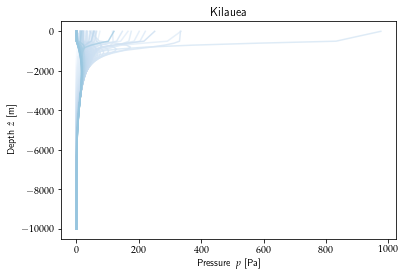

In [115]:
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_combined = np.zeros((101,len(file_dates)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_combined[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_combined[5::] = u.T

y = np.arange(0,1e4+dy,dy) 
max_u_comb = []
for j,k in enumerate(y):
    max_u_comb.append(max(u_combined[j]))
 
for num in range(len(y)):
    plt.plot(u_combined[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42%

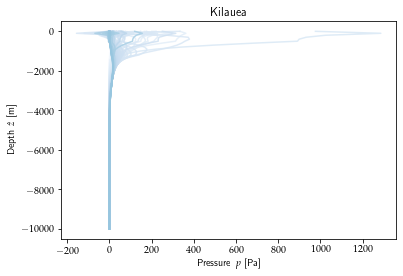

In [117]:
# %%time 
'''
Model parameters and implementation for 3-domain half-space (permeable layer overlying less permeable layers)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_3_stage = np.zeros((101,len(file_dates)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=ki[0], phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_3_stage[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=ki[1], phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_3_stage[5::] = u.T
p_new = u.T[7]
######### domain  [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=1200, k=ki[2], phi=0.01, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 3")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_3_stage[12::] = u.T

y = np.arange(0,1e4+dy,dy)

max_u_3 = []
for j,k in enumerate(y):
    max_u_3.append(max(u_3_stage[j]))
    
for num in range(len(y)):
    plt.plot(u_3_stage[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  

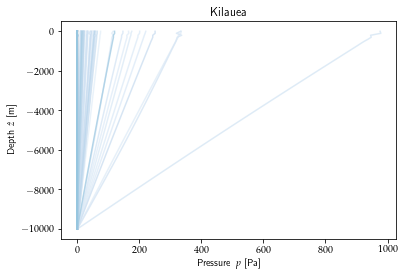

In [126]:
'''
Model parameters and implementation for single-domain half-space (arithmetic permeability)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_kx = np.zeros((101,len(file_dates)))

######### domain 1 [arithmetic permeability]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=kx, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_kx = u.T.copy()


y = np.arange(0,1e4+dy,dy) 
max_u_kx = []
for j,k in enumerate(y):
    max_u_kx.append(max(u_kx[j]))
 
for num in range(len(y)):
    plt.plot(u_kx[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  

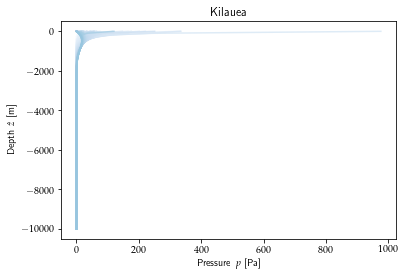

In [130]:
'''
Model parameters and implementation for single-domain half-space (geometric permeability)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_kx = np.zeros((101,len(file_dates)))

######### domain 1 [geometric permeability]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=kg, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_kg = u.T.copy()


y = np.arange(0,1e4+dy,dy) 
max_u_kg = []
for j,k in enumerate(y):
    max_u_kg.append(max(u_kg[j]))
 
for num in range(len(y)):
    plt.plot(u_kg[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


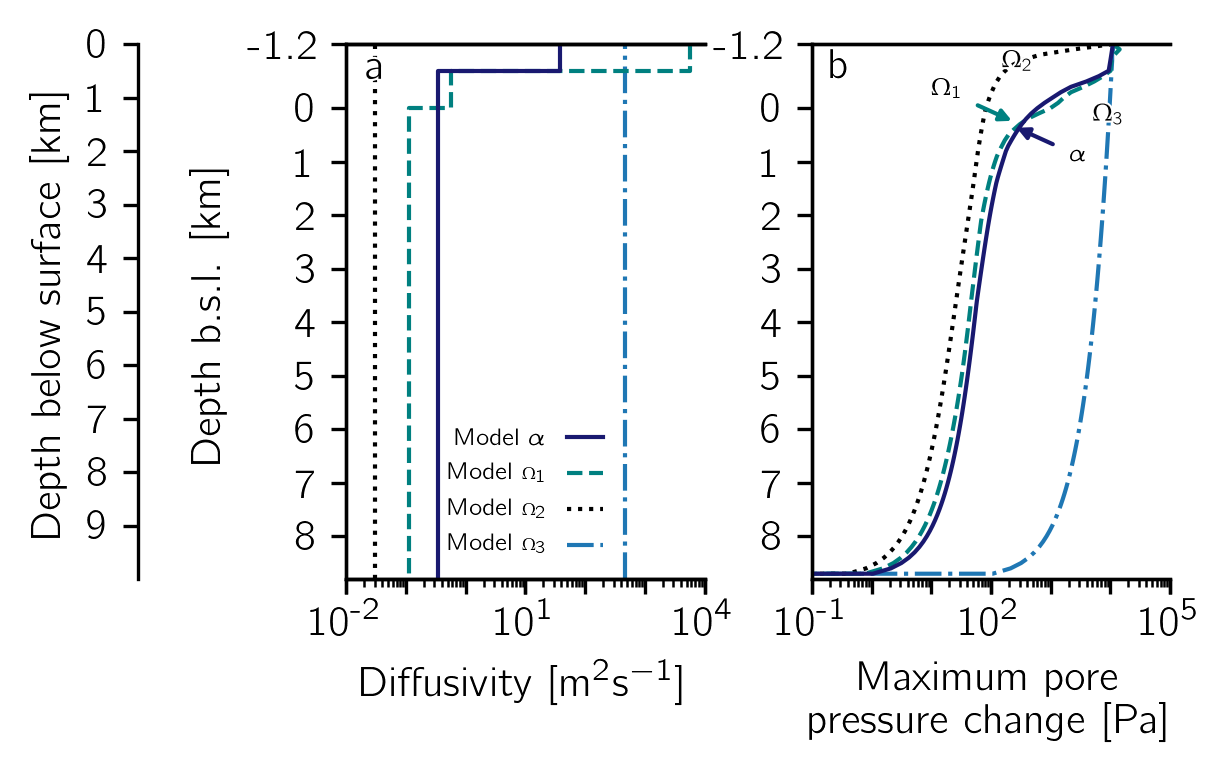

In [146]:
'''
Plots Figure 3, diffusivities of discrete models and maximum pressure change effected at depth.
'''  
fig = plt.figure(1, figsize=(mm2inch(90,60)), frameon=True, dpi=300)
plt.rcParams["font.family"] = 'sans-serif'
ax1= fig.add_subplot(121)
variable_diff = []
for z in range(len(y)):
    if z < int(500/y_max*len(y)):
        variable_diff.append(alpha(k=ki[0]))
    elif z < int(1200/y_max*len(y)):
        variable_diff.append(alpha(k=ki[1]))
    else    :
        variable_diff.append(alpha(k=ki[2], phi = 0.01))
variable_diff2 = []
for z in range(len(y)):
    if z < int(500/y_max*len(y)):
        variable_diff2.append(alpha(k=1e-12, phi=0.3))
    else    :
        variable_diff2.append(alpha(k=6e-15, phi = 0.2))


ax1.step(variable_diff2, y, "midnightblue", linestyle = "solid", label = r"Model $\alpha  $", zorder = 10, linewidth = 1)
ax1.step(variable_diff, y, "teal", label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_1$', linestyle="dashed",linewidth = 1, zorder = 9)
ax1.axvline(x=alpha(k=kg, phi = 0.2), color="k", linestyle = ":",zorder = 0, label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_2$', linewidth = 1)
ax1.axvline(x=alpha(k=kx, phi = 0.2), linestyle = "-.", zorder = 0, label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_3$', linewidth = 1)


ax1.set_xscale("log")
ax1.set_xlabel(r"Diffusivity [m$^2$s$^{-1}$]")
ax1.set_ylabel(r"Depth b.s.l. [km]")
ax1.set_ylim([10000,0])

ax1.set_xlim([1e-4,1e4])
# plt.xticklabels([1e-4,0,1e4])
plt.legend(fancybox = "None",edgecolor="None", loc = 8,facecolor = "w",
           markerfirst = False, framealpha=0., handlelength = 1.5,
          fontsize="xx-small").set_zorder(12)
ax2 = fig.add_subplot(122)

ax2.plot(max_u_comb,y, "midnightblue", linestyle = "solid", linewidth = 1, zorder = 10)
ax2.plot(max_u_kg,y, "k", linestyle = ":", linewidth = 1)
ax2.plot(max_u_3,y, "teal", linewidth = 1, linestyle = "dashed")
ax2.plot(max_u_kx,y, linestyle = "-.", zorder = 0, linewidth = 1)
ax2.set_xscale("log")
ax2.set_ylim([10000,0])
ax2.set_xlabel("Maximum pore\npressure change [Pa]")
ax2.yaxis.label.set_visible(False)
ax2.set_xlim([1e-1,1e5])

plt.rcParams["font.family"] = 'sans-serif'
ax1.xaxis.set_major_formatter(LogFormatterTexTextMode())
ax2.xaxis.set_major_formatter(LogFormatterTexTextMode())

ax1.annotate("a", xy=(2e-2,650),xycoords = "data", weight = "bold", path_effects = buffer)
ax2.annotate("b", xy=(2e-1,650),xycoords = "data", weight = "bold")

plt.subplots_adjust(wspace=0.3)#52)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(-1*(-x/1000+1.2)))
ax1.yaxis.set_major_formatter(ticks_y)
ax1.set_yticks([0,1200,2200,3200,4200,5200,6200,7200,8200, 9200])
ax1.set_yticklabels([-1.2, 0, 1, 2, 3, 4, 5, 6, 7, 8])
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_yticks([0,1200,2200,3200,4200,5200,6200,7200,8200, 9200])
ax2.set_yticklabels([-1.2, 0, 1, 2, 3, 4, 5, 6, 7, 8])

ax3 = ax1.twinx()
ax3.set_ylim([10,0])
ax3.set_yticks([0,1,2,3,4,5,6, 7, 8, 9 ])
ax3.set_ylabel(r"Depth below surface [km]")
ax3.spines['left'].set_position(('outward', 50))
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax3.yaxis.set_major_formatter(ticks_y)
ax1.spines["right"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax3.spines["right"].set_visible(False)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax1.xaxis.set_major_locator(locmaj)
ax2.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_xticks([1e-2,1e1,1e4])
ax2.set_xticks([1e-1,1e2,1e5])
ax1.set_xlim([1e-2,1e4])
ax4 = ax1.twiny()
ax4.xaxis.tick_bottom()
ax4.set_xlim([1e-2,1e4])
ax4.set_xscale("log")
ax4.xaxis.set_major_locator(locmaj)
ax4.set_xticklabels([])
ax5 = ax2.twiny()
ax5.xaxis.tick_bottom()
ax5.set_xlim([1e-1,1e5])
ax5.set_xscale("log")
ax5.xaxis.set_major_locator(locmaj)
ax5.set_xticklabels([])
ax4.spines["right"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax2.annotate(r"$\alpha$", xy=(200,1500),xycoords = "data", fontsize = "xx-small",
            xytext=(2e3,2.2e3),
            arrowprops={'arrowstyle': '-|>', 'color' : "midnightblue"})#, path_effects = buffer)

ax2.annotate(r'$\Omega_1$', xy=(300,1500),xycoords = "data", fontsize = "xx-small",
            xytext=(1e1,1e3),
            arrowprops={'arrowstyle': '-|>', 'color' : "teal"})
ax2.annotate(r'$\Omega_2$', xy=(150,500),xycoords = "data", fontsize = "xx-small", path_effects = buffer)
ax2.annotate(r'$\Omega_3$', xy=(5e3,1500),xycoords = "data", fontsize = "xx-small", path_effects = buffer)

# plt.savefig(filepath+"/figures/kil_fig_3.pdf", bbox_inches='tight')
plt.show()

**Figure 3 |** a Diffusivity (a function of permeability k , bulk modulus K , fluid viscosity μ , and porosity φ given by kK/μφ ) against depth (depth below the surface and depth b.s.l. are shown for reference) for four different models ( k − φ scenarios, summarised in Table 1). The primary model (Model α ) is a
two-layer model, with a zone of high porosity and permeability overlying a lower permeability domain.
Reference model Ω subdivides the lower domain into two, each with different properties. Models 1 Ω2
and Ω are single-domain models, meaning that they use values of porosity, permeability, bulk 3
modulus, and viscosity that are constant with depth. Further detail is given in the Methods. b The
maximum pressure change effected at depth in each model throughout the modelled time-series. Note
that the maximum pressure change for any given depth can occur on multiple dates, and may not be
consecutive. For example, high values near the surface may occur frequently (see Fig. 4a, b) but may not
propagate to depth. On the other hand, high pressure at depth may not be a direct consequence of a
single spike at the surface.

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41

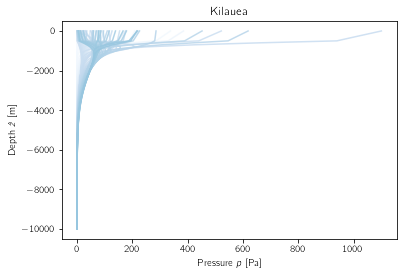

CPU times: user 46min 12s, sys: 21min 11s, total: 1h 7min 23s
Wall time: 51min 17s


In [175]:
%%time
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer),
over long time-frame (gauge data only)
'''

lt_rainfall_m=lt_ki_rain.rain/1e3

pzlt = []
rho = 997.
g = 9.80665
for j,k in enumerate(lt_rainfall_m):
    pzlt.append(lt_rainfall_m[j]*rho*g) # pressure defined as a pseudovector, assuming the height of rainfall (in m), the density of water, and acceleration due to gravity.
pzlt = [0 if np.isnan(x) else x for x in pzlt]

del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_comb_lt = np.zeros((101,len(lt_ki_rain.date)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pzlt))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pzlt[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_comb_lt[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pzlt))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_comb_lt[5::] = u.T

y = np.arange(0,1e4+dy,dy) 
 
for num in range(len(y)):
    plt.plot(u_comb_lt[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


In [157]:
kilauea_intrusions_all =[
    "1963-05-09",
    "1963-07-02",
    "1965-08-25",
    "1969-03-21",
    "1969-07-03",
    "1969-11-03",
    "1970-01-22",
    "1973-06-09",
    "1974-03-24",
    "1976-06-21",
    "1976-07-14",
    "1977-02-08",
    "1979-05-29",
    "1980-03-02",
    "1980-07-30",
    "1980-08-27",
    "1980-10-22",
    "1980-11-02",
    "1981-08-10",
    "1982-03-23",
    "1982-06-22",
    "1982-12-09",
    "1969-10-07",
    "1971-12-23",
    "1981-01-20",
    "1981-01-24",
    "1981-02-09",
    "1981-08-02",
    "1990-12-04",
    "1991-03-26",
    "1991-08-21",
    "1992-03-03",
    "1993-02-07",
    "1997-01-29",
    "1999-09-12",
"1979-08-12",
"1980-10-21",
    
"2000-02-23",
"2007-06-17",
"2011-03-05",
"2011-08-03",
"2011-09-21",
"2012-10-15"]

In [183]:
'''
Calculate 4 year rolling mean pressure
'''
yrs = 4
roll_mean_lt = pd.DataFrame(u_comb_lt[30]).rolling(int(yrs*365)).mean()
roll_mean = pd.DataFrame(u_combined[30]).rolling(int(yrs*365)).mean()


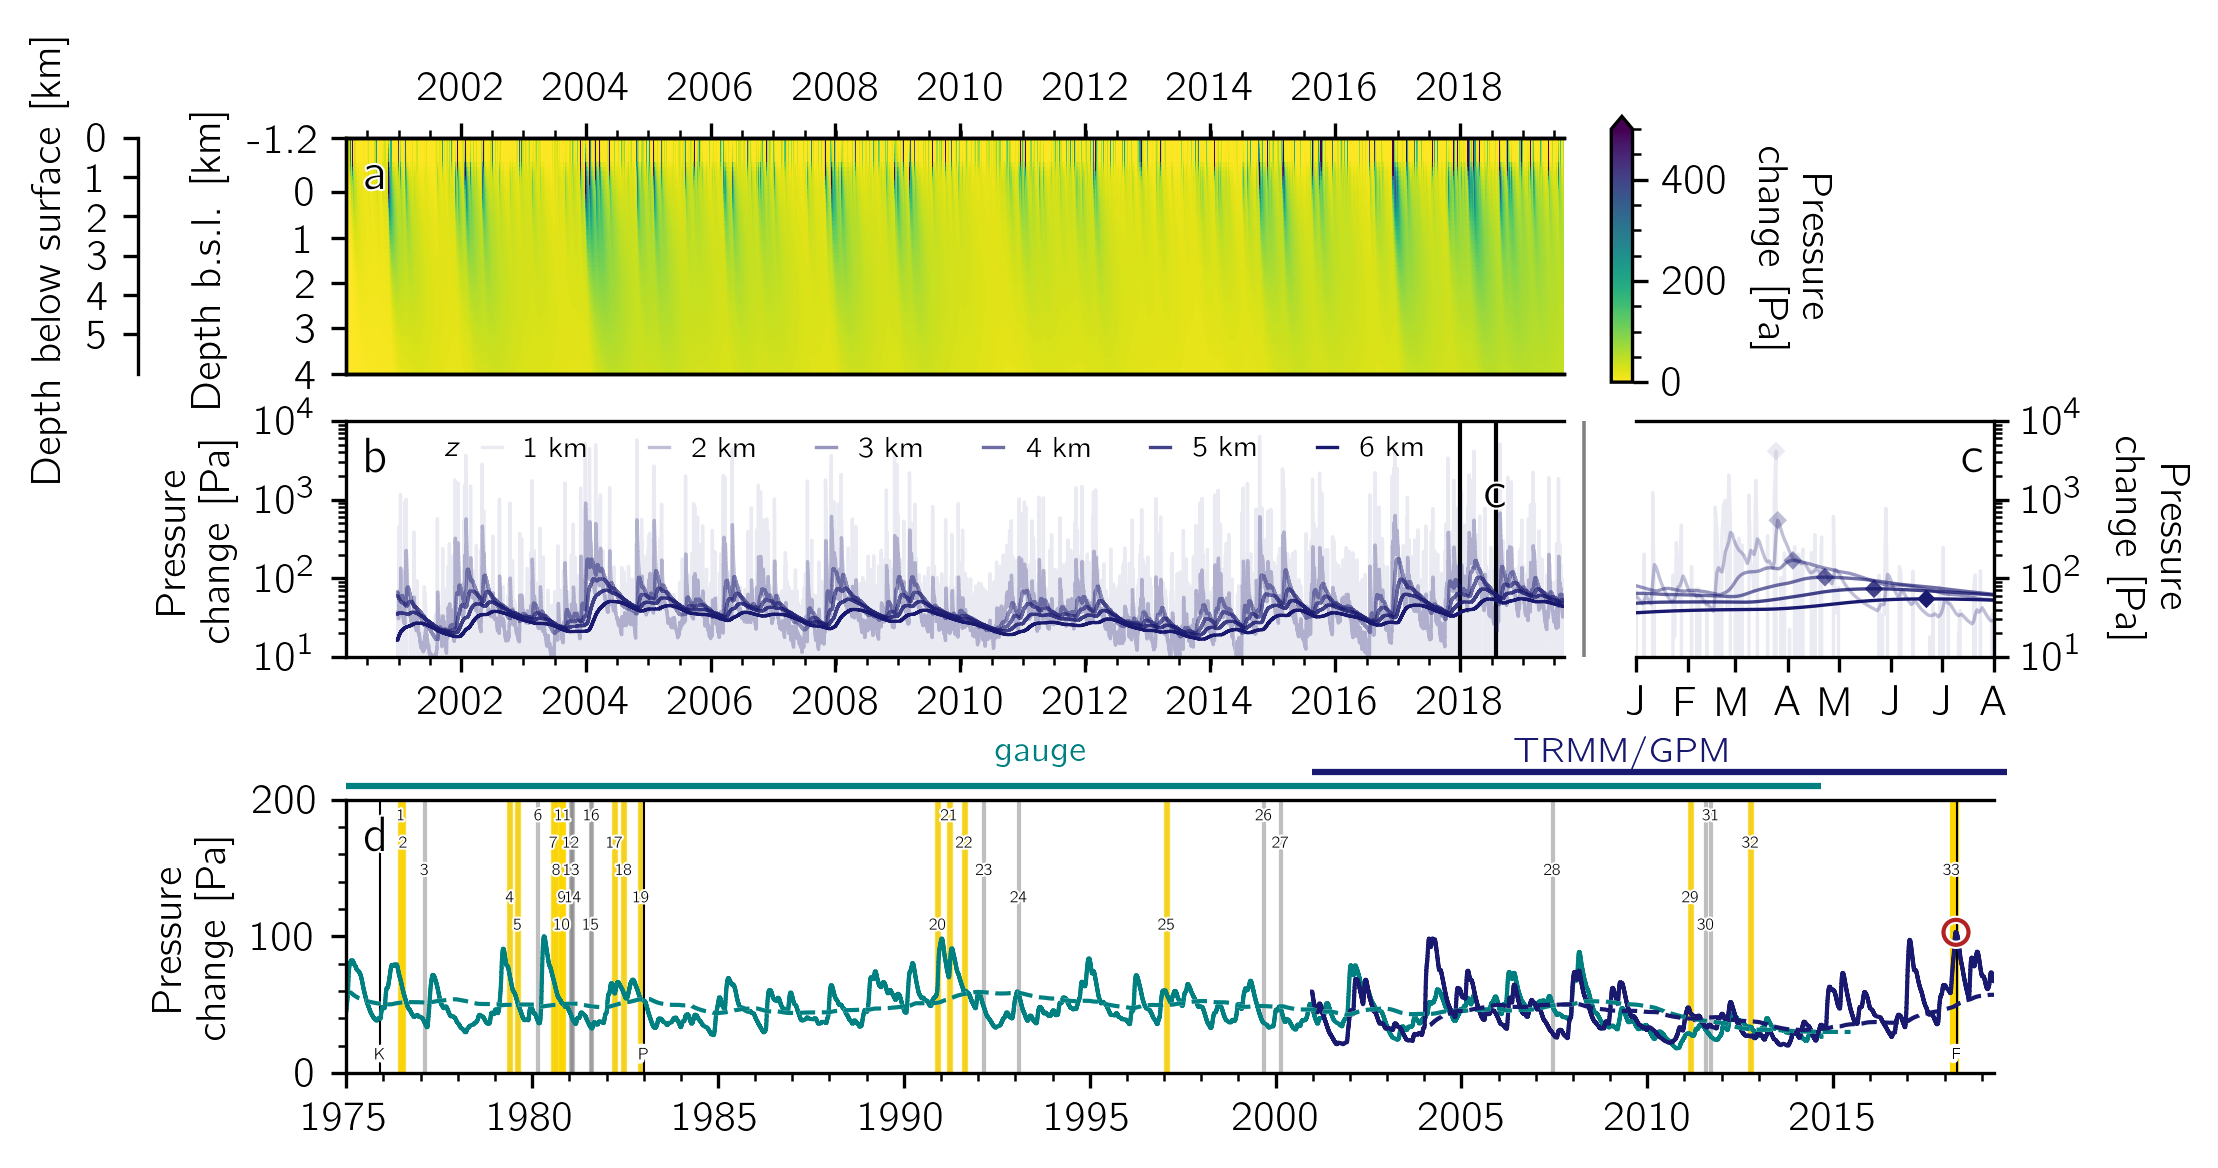

In [199]:

################# set up axes ###################

fig = plt.figure(1, figsize=(mm2inch(180,90)), frameon=True, dpi=300)
gs0 = plt.GridSpec(3, 4, hspace=0.2)
gs = plt.GridSpec(3, 4,top = 1.8, bottom = 0, hspace=2)

ax0 = plt.subplot(gs0[0,:-1])
ax1 = plt.subplot2grid((3, 4), (1, 0), colspan = 3)
ax2 = plt.subplot2grid((3, 4), (1, 3), colspan = 1)
ax3 = plt.subplot(gs[2,:])

############ set up axes formatting ##############

ml = MultipleLocator(20)
years = mdates.YearLocator() 
months = mdates.MonthLocator() 
monthsFmt = DateFormatter("%b")
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)


################# bgn panel a ###################

cmap = pylab.cm.viridis_r
im = ax0.imshow((u_combined[:][0:53]), aspect = 'auto', cmap = cmap, vmin=0, vmax = 500)

ax0.get_xaxis().set_ticks([])
ax0.set_ylabel(r'Depth b.s.l. [km]')

ax0a = ax0.twiny()
ax0a.plot([],[]) # Dummy plot
ax0a.set_xlim(min(file_dates), max(file_dates))
ax0a.set_ylim(52,0)
ax0a.xaxis.set_ticks_position('top')

dy = 100
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((-(-x*dy+1200)/1000)))

ax0a.yaxis.set_major_formatter(ticks_y)
ax0a.set_yticks([0,12, 22, 32, 42, 52])


ax0b = ax0a.twinx()
ax0b.set_ylim([6,0])
ax0b.set_yticks([0,1,2,3,4,5, ])
ax0b.set_ylabel(r"Depth below surface [km]")
ax0b.spines['left'].set_position(('outward', 50))
ax0b.yaxis.set_label_position("left")
ax0b.yaxis.tick_left()
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax0b.yaxis.set_major_formatter(ticks_y)

ax0b.minorticks_on()
ax0b.yaxis.set_minor_locator(MultipleLocator(5))

ax0.spines['right'].set_visible(False)
ax0a.spines['right'].set_visible(False)
ax0b.spines['right'].set_visible(False)

####### panel a annotations #######

ax0.annotate("a", (0, 1),xytext=(4, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top')

####### panel a annotations #######

################# end panel a ###################

################# bgn panel b ###################

ax1.set_xlim(min(file_dates), max(file_dates))
ax1.set_ylim(10,10000)
for line in range(0,51,10):
    ax1.step(file_dates[300::],u_combined[line][300::],
             color = "midnightblue", lw = 0.8, ls = "solid", where = 'mid', alpha = (line+5)/55,
            label = "{} km".format(int(line/10+1)))
legend = ax1.legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper left', bbox_to_anchor=(0.09, 1.05),
                   framealpha=0, ncol = 6)#loc = 9)#"upper center")
legend.get_frame().set_linewidth(0.8)
ax1.set_ylabel("Pressure\nchange [Pa]")
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax1.yaxis.set_major_formatter(ticks_y)
ax1.set_yscale("log")
ax1.xaxis.set_ticks_position('bottom')
ax1.xaxis.set_label_position('bottom')
ax1.spines['right'].set_visible(False)
ax1.axvline(x="2018-01-01", color = "k", linewidth = 1, zorder = 0)
ax1.axvline(x="2018-08-01", color = "k", linewidth = 1, zorder =0)

ax1.yaxis.set_major_formatter(LogFormatterTexTextMode())

ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


ax1.minorticks_on()
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.vlines(x="2020-01-01", ymin = 10, ymax = 1e4, clip_on=False, linewidth = 0.85, color = "grey")


####### panel b annotations #######

ax1.annotate("$z$", xy = (0.08, 0.85), xycoords = 'axes fraction', fontsize = "x-small")
ax1.annotate("b", (0, 1),xytext=(4, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top')
ax1.annotate("c", (0.92,0.85),xytext=(4, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top'
            )             

####### panel b annotations #######

################# end panel b ###################


################# bgn panel c ###################

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
for line in range(0,51,10):
    ax2.plot(file_dates[300::],u_combined[line][300::], color = "midnightblue", lw = 0.8,
             ls = "solid", alpha = (line+5)/55,
            label = "{} km".format(int(line/10+1)))
    ax2.scatter(file_dates[np.argmax(u_combined[line][6515:6700])+6515], max(u_combined[line][6515:6700]),
                marker = 'D', color = 'midnightblue', edgecolor = 'None', s=10, alpha = (line+5)/55)
ax2.set_xlim("2018-01-01", "2018-08-01") 
ax2.set_yscale("log")
ax2.set_ylim([10,10000])
ax2.set_ylabel("Pressure\nchange [Pa]", rotation = 270, labelpad = 25)

ax2.spines['left'].set_visible(False)

ax2.xaxis.set_major_locator(months)
ax2.yaxis.set_major_formatter(LogFormatterTexTextMode())
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_major_locator(months)
ax2.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A"])


####### panel c annotations #######

ax2.annotate("c", (1, 1),xytext=(-8, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top')

####### panel c annotations #######

################# end panel c ###################

################# bgn panel d ###################

ax3.step(lt_ki_rain.date[:-100], u_comb_lt[30][:-100], color = "teal", lw =1, alpha = 1., clip_on = True, where = 'mid')#, path_effects=buffer)
ax3.step(file_dates[300::], u_combined[30][300::], color = "midnightblue", lw = 1, linestyle = "solid", where = 'mid')#, path_effects=buffer)
ax3.bar(kilauea_intrusions_all, height = 200, edgecolor = "grey", width = 0.1, zorder = 0, alpha = 0.5, color = None)
ax3.set_ylabel("Pressure\nchange [Pa]")
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax3.yaxis.set_major_formatter(ticks_y)
ax2.xaxis.set_ticks_position('bottom')
ax3.fill_between(file_dates[6588:6640],200, 
                 color = "gold", 
                 edgecolor = "None",
                )

ax3.annotate(r"gauge", xy = ("06-01-1992", 150), color ='teal',xycoords = "data", fontsize = "small", xytext = ("06-01-1992", 228))
ax3.annotate(r"TRMM/GPM", xy = ("06-01-2009", 150), color = 'midnightblue',xycoords = "data", fontsize = "small", xytext = ("06-01-2006", 228))
ax3.spines['right'].set_visible(False)
ax3.hlines(y = 210, xmin = "1975-01-01", xmax = max(lt_ki_rain.date[:-100]), clip_on = False, color = "teal")
ax3.hlines(y = 220, xmin = file_dates[300], xmax = max(file_dates), clip_on = False, color = "midnightblue")
ax3.scatter(file_dates[np.argmax(u_combined[30])], 103, marker = "o", color = "none", edgecolor = "firebrick", 
            path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], zorder = 999)#path_effects=buffer, zorder = 999)
ax3.xaxis.set_label_position('bottom')
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax3.yaxis.set_major_formatter(ticks_y)
ax3.step(lt_ki_rain.date, roll_mean_lt, color = "teal", linewidth = 1, linestyle = "dashed", alpha = 1, path_effects=buffer, where = 'mid')
ax3.step(file_dates[100::], roll_mean[100::], color = "midnightblue", linewidth = 1, linestyle = "dashed", alpha = 1, where = 'mid')#, path_effects=buffer)
ax3.set_xlim(["1975-01-01", "2019-05-01"])
ax3.set_ylim([0,200])
cnt = sum(j < 1975 for j in ([int(k[0:4]) for k in kilauea_intrusions_all]))
for ix,num in enumerate(sorted(kilauea_intrusions_all)):
    if int(num[0:4]) >= 1975:
        j = (ix-cnt+1)
        if j in range(0,len(kilauea_intrusions_all),5):
            ax3.annotate("{}".format(j), fontsize = 4, xy = (num, 105), path_effects = buffer, ha = "center")
        elif j in range(1,len(kilauea_intrusions_all),5):
            ax3.annotate("{}".format(j), fontsize = 4, xy = (num, 185), path_effects = buffer, ha = "center")
        elif j in range(2,len(kilauea_intrusions_all),5):
            ax3.annotate("{}".format(j), fontsize = 4, xy = (num, 165), path_effects = buffer, ha = "center")
        elif j in range(3,len(kilauea_intrusions_all),5):
            ax3.annotate("{}".format(j), fontsize = 4, xy = (num, 145), path_effects = buffer, ha = "center")
        else:
            ax3.annotate("{}".format(j), fontsize = 4, xy = (num, 125), path_effects = buffer, ha = "center")
for num in kilauea_intrusions_all:
    if int(num[0:4]) >= 1975:
        if u_comb_lt[30][[str(x) for x in lt_ki_rain.date].index(num)] >= roll_mean_lt[0][[str(x) for x in lt_ki_rain.date].index(num)]:
            ax3.axvline(x=num, color = "gold", zorder =1, alpha = 0.8) 
for num in kilauea_intrusions_all:
    if int(num[0:4]) >= 2002:
        if u_combined[30][[str(x) for x in ki_rain.date].index(num)] >= roll_mean[0][[str(x) for x in ki_rain.date].index(num)]:
            ax3.axvline(x=num, color = "gold", zorder =1, alpha = 0.8)   

ax3.axvline(x="1975-11-29", color = "k", linewidth = 0.5,zorder = 0, linestyle = "solid")
ax3.axvline(x="1983-01-03", color = "k", linewidth = 0.5,zorder = 1, linestyle = "solid")
ax3.axvline(x="2018-05-03", color = "k", linewidth = 0.5,zorder = 1, linestyle = "solid")

ax3.xaxis.set_minor_locator(years)
ax3.yaxis.set_minor_locator(ml)

####### panel d annotations #######

ax3.annotate("K", fontsize = 4, xy = ("1975-11-29", 10), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center')
ax3.annotate("P", fontsize = 4, xy = ("1983-01-03", 10), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
ax3.annotate("F", fontsize = 4, xy = ("2018-05-03", 10), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
ax3.annotate("33", fontsize = 4, xy = ("2018-03-15", 145), path_effects = buffer, ha = "center")

ax3.annotate("d", (0, 1),xytext=(4, -4),xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top')

####### panel d annotations #######


################# end panel d ###################


################# colourbar ###################

cbar_ax = fig.add_axes([0.72,0.65, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax, extend = "max", orientation = "vertical")#, ticks=[0,0.5, 1, 1.125])#, norm=mpl.colors.Normalize(vmin=-0.5, vmax=1.5))
cbar_ax.set_ylabel('Pressure\nchange [Pa]', rotation = 270, labelpad = 25)
cbar_ax.set_yticks([0,100,200,300,400,500])
cbar_ax.minorticks_on()
cbar_ax.yaxis.set_major_formatter(ticks_y)

################ save and show ################

# plt.savefig(filepath+"/figures/kil_fig_4.png", bbox_inches='tight')
plt.show()


**Figure 4|** Rainfall infiltration into Kīlauea’s edifice. a Pore pressure change with depth and time, using
daily rainfall data (see Fig. 2a) as a fluctuating boundary condition. Color scale indicates pressure
change. b Pore pressure change at depths of 1, 2, 3, 4, 5, and 6 km below the surface over time. c
Detailed view of b, showing model results from Jan 2018 to Aug 2018. Diamonds indicate the maximum
value for each depth over that timeframe, illustrating the propagation of a pore pressure front from the
surface (1.2 km a.s.l.) to 4.8 km b.s.l. (i.e. from 0 to 6 km below the surface) over time. d Pore pressure
change at 3 km below the surface (1.8 km b.s.l.) modelled over the period Jan 1975–Apr 2019, using
available HVNP gauge data (1950–2015) and calibrated satellite data (2000–2019: see b). Dashed line is
the 4-year running average. K = 1975 M 7.2 Kalapana earthquake; P = 1983 onset of Pu‘u ‘Ō‘ō eruption; K
= 2018 Kīlauea rift intrusion–eruption. Numbered vertical bars indicate reported intrusion events within
the rift zone, after Klein et al. [1987] (1—19), Heliker and Mattox [2003] (20—27), Poland et al. [2014]
(28), and Orr et al. [2015] (29—32). Intrusions are highlighted in yellow if they coincide with periods
where pressure change exceeds the 4-year average, and grey if they do not. Intrusion 33 in this
time-series corresponds to the early 2018 activity (intrusion detected mid-March, followed by the rift
eruption on 3 May). Circle highlights the maximum pore pressure perturbation over this timeframe
(1975—2019), coinciding with the onset of 2018’s rift eruption. Horizontal bars indicate data availability.

In [211]:
'''
Read in supplementary data for the Paradise Parks/ Hawai`ian Beaches areas. Paradise data are well level data, Beaches data are rain gauge data. 
Paradise well level data are digitised from the Ph.D. thesis of Steve Gingerich: 
Gingerich, S.B., 1997. "The hydrothermal system of the Lower East Rift Zone of Kilauea Volcano: Conceptual and numerical models 
of energy and solute transport." University of Hawai`i at Manoa.

'''
paradise = pd.read_csv(filepath+"/gauge_data/paradise.csv", header=None, names=["Date", "level_m"],)
beaches = pd.read_csv(filepath+"/gauge_data/1768285.csv")

'''
Fix date formats
'''
bea = []
for x in beaches.DATE:
    bea.append(dt.datetime.strptime(x, "%Y-%m-%d"))
beaches["date"] = bea

para = []
for x in paradise.Date:
    para.append(dt.datetime.strptime(x, "%Y/%m/%d"))
paradise["date"]= para

'''
Convert rainfall to a pressure input
'''
beaches_m=beaches.PRCP/1e3 #*25.4

pz0_b = []
rho = 997.
g = 9.80665
for j,k in enumerate(beaches_m):
    pz0_b.append(beaches_m[j]*rho*g) 
pz0_b = [0 if np.isnan(x) else x for x in pz0_b]

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42%

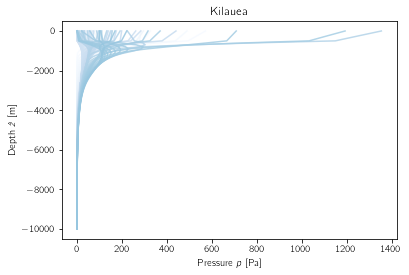

In [216]:
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_comb_para = np.zeros((101,len(pz0_b)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pz0_b))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0_b[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_comb_para[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pz0_b))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p,1)
    u[num] = pout[0]
u_comb_para[5::] = u.T

y = np.arange(0,1e4+dy,dy) 

for num in range(len(y)):
    plt.plot(u_comb_para[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


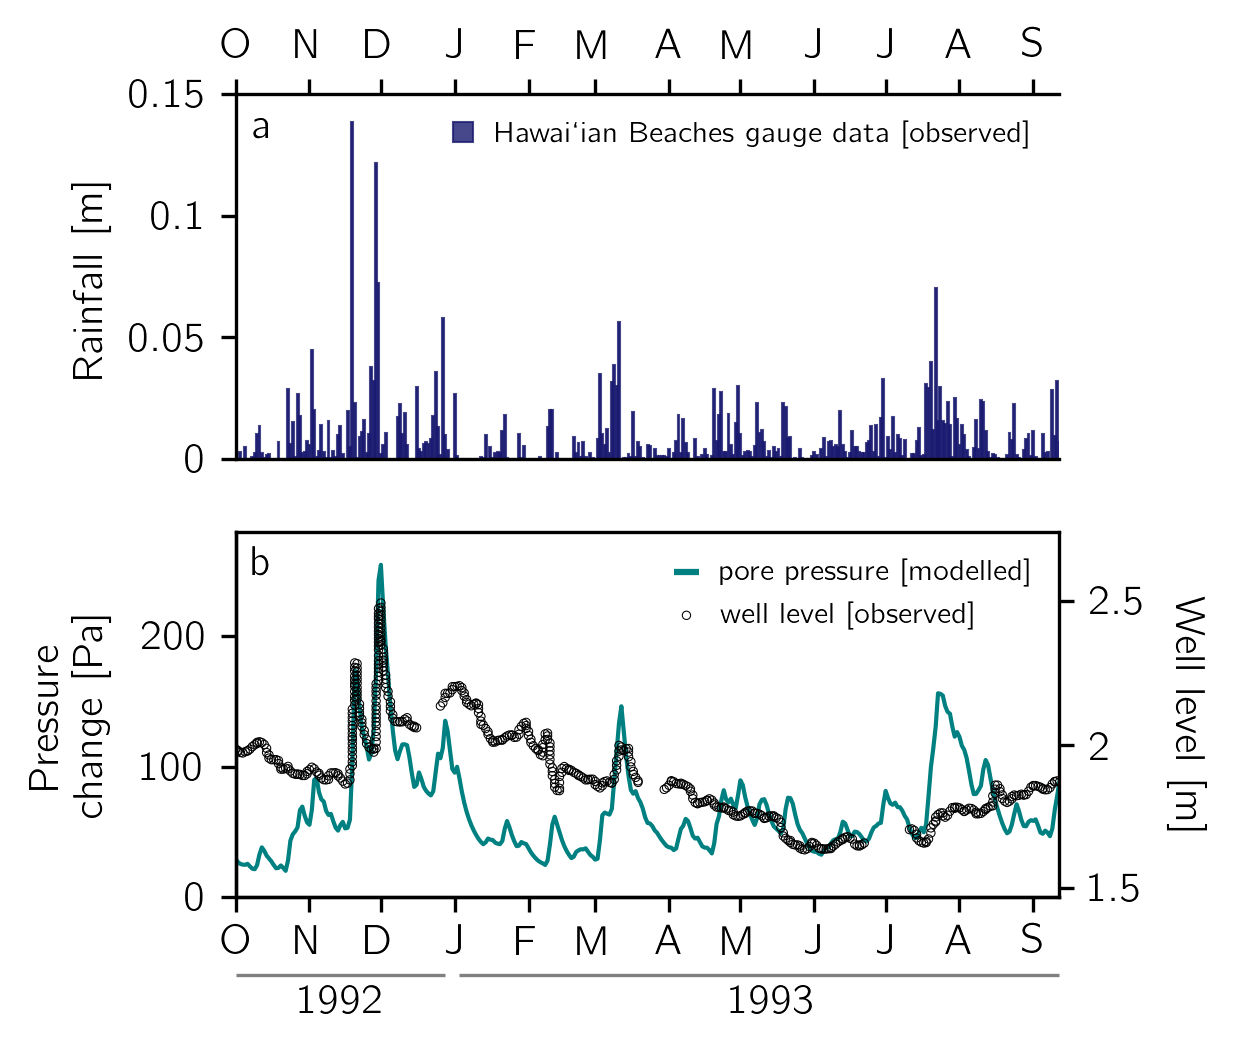

In [218]:
'''
Plots Supplementary figure 1: Comparison of modelled pore pressure change at depth and recorded well level data from Paradise Park.
'''
axlabels2= ["O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A", "S"]
fig =  plt.figure(figsize=(mm2inch(90,90)), frameon=True, dpi=300)
ax1 = fig.add_subplot(211)
ax1.bar(beaches.date, beaches_m, color="midnightblue", linewidth = .5, edgecolor = "midnightblue",alpha =0.8,
       label = "Hawai`ian Beaches gauge data [observed]")
legend = ax1.legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper right',
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)
ax1.set_xlim(["1992-10-01", max(paradise.date)])

ax1.set_xticklabels([])
ax1.set_ylabel("Rainfall [m]")
ax1.annotate("a", xy = (0.02,0.88), xycoords="axes fraction")

ax2 = fig.add_subplot(212)
ax3= ax2.twinx()
ax3.scatter(paradise.date, paradise.level_m, facecolor = "None",linewidth = 0.25,color = "k", marker = "o",s = 4)
ax3.set_ylabel("Well level [m]", rotation = 270, labelpad = 15)


ax2.plot(beaches.date[22:400], u_comb_para[10][22:400], color = "teal" ,linewidth = 1)#, where = 'mid')
ax2.set_xlim(["1992-10-01", max(paradise.date)])
ax2.set_ylabel("Pressure\nchange [Pa]")
axlabels= ["1992-10", "1992-11", "1992-12", "1993-01","1993-02","1993-03","1993-04","1993-05","1993-06","1993-07","1993-08","1993-09"]
ax2.set_xticks(axlabels)
ax2.set_xticklabels(axlabels)#, rotation = 90)
ax2.set_xticklabels(axlabels2)

ax2.annotate("b", xy = (0.02,0.88), xycoords="axes fraction")
ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0,250)
ax2.hlines(xmin="1992-10-01", xmax = "1992-12-28",y=-60, clip_on=False, linewidth = 0.8, color = "grey")
ax2.annotate("1992", xy = ("1992-11-01", 0), xycoords = 'data',xytext = ("1992-11-15", -90), ha = "center", clip_on=False)
ax2.hlines(xmin="1993-01-03", xmax = max(paradise.date),y=-60, clip_on=False, linewidth = 0.8, color = "grey")
ax2.annotate("1993", xy = ("1993-05-01", 0), xycoords = 'data',xytext = ("1993-05-15", -90), ha = "center", clip_on=False)
ax1.xaxis.tick_top()
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax1.yaxis.set_major_formatter(ticks_y)
ax2.yaxis.set_major_formatter(ticks_y)
ax3.yaxis.set_major_formatter(ticks_y)
ax1.set_ylim(0,.15)
ax2.set_ylim(0,280)
ax3.set_ylim(1.47,2.74)

ax1.set_xticklabels(axlabels2)
marker_1 = plt.scatter([],[], color = "teal", marker = "_",alpha = 1., lw=1.5,label = "pore pressure [modeled]")
marker_2 = plt.scatter([],[], facecolor = "None",linewidth = 0.25,color = "k", marker = "o",s = 4, label = "well level [observed]", zorder = 10)

legend = plt.legend([marker_1, marker_2],["pore pressure [modelled]","well level [observed]"],fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper right',
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)

fig.align_ylabels()
# plt.savefig(filepath+"/figures/kil_fig_s1.png", bbox_inches="tight")
plt.show()

**Figure S1|** Comparison of recorded head change and modelled pressure change. a Rainfall
data obtained from the Hawai‘i Beaches rain gauge (refer to Fig. 1a [inset] for location). b
Paradise Park Well data (see Fig. 1a [inset] for location of well), digitised from Gingerich [1995]
over the time period Oct 1992–Sep 1993. Pressure evolution at 1 km depth modelled using rain
data from a.